# ANNDL - Challenge 1

### Importation

In [1]:
import os
import random
import matplotlib.pyplot as plt
import PIL
import PIL.Image

import tensorflow as tf
import cython as ct
import numpy as np
import matplotlib as mpl
import seaborn as sns
import scipy as sp
import sklearn as sk
import pandas as pd

tfk = tf.keras
tfkl = tf.keras.layers

print('Tensorflow: ', tf.__version__)
print('Cython: ', ct.__version__)
print('Numpy: ', np.__version__)
print('Matploit: ', mpl.__version__)
print('Seaborn: ', sns.__version__)
print('Scipy: ', sp.__version__)
print('Scikit-learn: ', sk.__version__)
print('Scikit-image: NOT INSTALLED')
print('Panda: ', pd.__version__)

Tensorflow:  2.9.2
Cython:  0.29.32
Numpy:  1.21.6
Matploit:  3.2.2
Seaborn:  0.11.2
Scipy:  1.7.3
Scikit-learn:  1.0.2
Scikit-image: NOT INSTALLED
Panda:  1.3.5


### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/'ANNDL'/'Challenge1'

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1wYXyoEwRqU1umxccIJJH4SamZKzkPV7x/ANNDL/Challenge1


### Turn off Tensorflow warnings

In [3]:
import warnings
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Set reproducibility seed

In [4]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Set parameters

In [5]:
original_dataset_dir = 'split_data'
image_size = 96
input_shape = (image_size, image_size, 3)
epochs = 250
result_folder_name = 'CNNs_folder'
neural_network_name = 'CNN_classification'
batch_size = 32


### Setting up image generator
The image generator is useful for creating a set of modifications for the images. However data it'not loaded yet. The dataset is split between training and validation set with a 80/20 split. The images modification used are only the vertical and horizontal flips to preserve the quality of the images. Moreover a brightness range is set to deal with the darkness of the dataset. 

In [6]:
# Create an instance of ImageDataGenerator with Data Augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode='reflect',
  brightness_range = [0.7, 1.5],
  rescale=1.0/255.0,
  validation_split = 0.20
)


### Image generator preview
In thes section we can have an idea of what the image generator will do to the images.

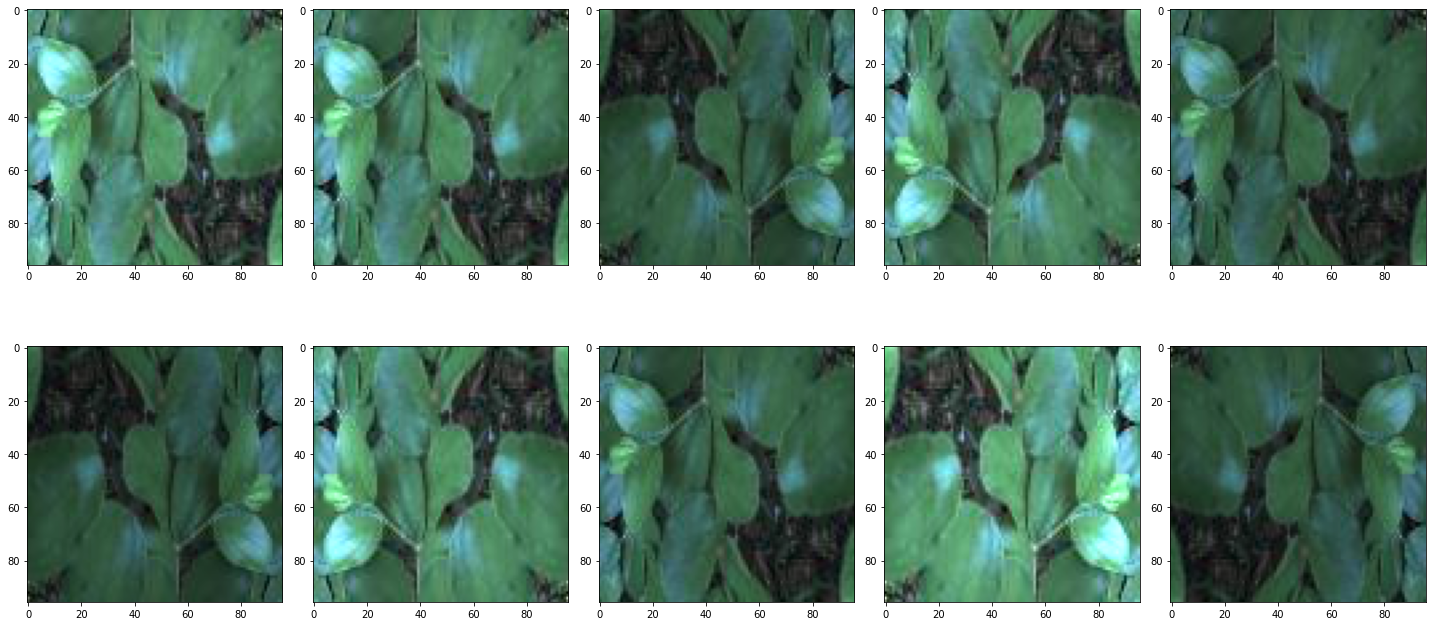

In [7]:
img =  tfk.preprocessing.image.load_img('Images/Dataset/Species1/00012.jpg')     # this is a PIL image
x = tfk.preprocessing.image.img_to_array(img)                                    # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)                                                    # this is a Numpy array with shape (1, 3, 150, 150)

#Plot
mod = data_gen.flow(x, batch_size=1)                                             

num_row = 2
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))

for i in range(10):
  y = mod.next()
  np.shape(mod.next())
  image = y[0]
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image)

plt.tight_layout()
plt.show()

### Data loading with ImageGenerator

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

train_set = data_gen.flow_from_directory(
    directory=('Images/Dataset'),
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    subset = 'training'
)

val_set = data_gen.flow_from_directory(
    directory=('Images/Dataset'),
    target_size=(image_size,image_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    classes=None,
    shuffle=True,
    subset = 'validation',
    seed=seed
)


Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


### Visualize random sample

In [9]:
labels = ['1', '2', '3', '4', '5', '6', '7', '8']

def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.float64(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: 2


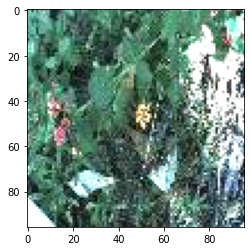

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(train_set)

### Model

In [11]:
def build_model(input_shape):
    
  model = tfk.Sequential()

  # Conolutional layer N°1 + Max Pooling
  model.add(tfkl.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(tfkl.AveragePooling2D())

  # Conolutional layer N°2 + Average Pooling 
  model.add(tfkl.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(tfkl.AveragePooling2D())

  model.add(tfkl.Dropout(0.3, seed=seed))
  
  # Conolutional layer N°3 + Max Pooling 
  model.add(tfkl.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(tfkl.AveragePooling2D())

  # Conolutional layer N°4 + Global Average Pooling + dropout to prevent overfitting
  model.add(tfkl.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed)))
  model.add(tfkl.GlobalAveragePooling2D())

  model.add(tfkl.Dropout(0.3, seed=seed))

  # Dense layer with 512 units + output layer with the 8 classes
  model.add(tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu'))
  model.add(tfkl.Dropout(0.3, seed=seed))
  model.add(tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer'))
  
  # Adam optimizer
  optimizer = tfk.optimizers.Adam()
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Return the model
  return model

### Callbacks and folder management function

In [12]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Submission/' + result_folder_name)
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

### Model preview

In [13]:
# Build model (for data augmentation training)
model = build_model(input_shape)
model.build((1, 96, 96, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 96, 96, 32)           896       
                                                                 
 average_pooling2d (AverageP  (1, 48, 48, 32)          0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (1, 48, 48, 64)           18496     
                                                                 
 average_pooling2d_1 (Averag  (1, 24, 24, 64)          0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (1, 24, 24, 64)           0         
                                                                 
 conv2d_2 (Conv2D)           (1, 24, 24, 128)          7

### Training

In [14]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name=neural_network_name) 

# Train the model
history = model.fit(
    x = train_set,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = val_set,
    callbacks = aug_callbacks,
).history

print('End of training')

Epoch 1/250
89/89 [==============================] - ETA: 0s - loss: 1.9459 - accuracy: 0.2292 

89/89 [==============================] - 1956s 22s/step - loss: 1.9459 - accuracy: 0.2292 - val_loss: 1.7404 - val_accuracy: 0.2918
Epoch 2/250
89/89 [==============================] - ETA: 0s - loss: 1.7138 - accuracy: 0.3205

89/89 [==============================] - 9s 105ms/step - loss: 1.7138 - accuracy: 0.3205 - val_loss: 1.6166 - val_accuracy: 0.3584
Epoch 3/250
89/89 [==============================] - ETA: 0s - loss: 1.5434 - accuracy: 0.4140

89/89 [==============================] - 9s 107ms/step - loss: 1.5434 - accuracy: 0.4140 - val_loss: 1.4766 - val_accuracy: 0.4405
Epoch 4/250
89/89 [==============================] - ETA: 0s - loss: 1.4758 - accuracy: 0.4309

89/89 [==============================] - 9s 102ms/step - loss: 1.4758 - accuracy: 0.4309 - val_loss: 1.4517 - val_accuracy: 0.4717
Epoch 5/250
89/89 [==============================] - ETA: 0s - loss: 1.4232 - accuracy: 0.4633

89/89 [==============================] - 9s 105ms/step - loss: 1.4232 - accuracy: 0.4633 - val_loss: 1.4159 - val_accuracy: 0.4334
Epoch 6/250
89/89 [==============================] - ETA: 0s - loss: 1.4119 - accuracy: 0.4676

89/89 [==============================] - 9s 105ms/step - loss: 1.4119 - accuracy: 0.4676 - val_loss: 1.3571 - val_accuracy: 0.4929
Epoch 7/250
89/89 [==============================] - ETA: 0s - loss: 1.3716 - accuracy: 0.4767

89/89 [==============================] - 9s 107ms/step - loss: 1.3716 - accuracy: 0.4767 - val_loss: 1.3410 - val_accuracy: 0.4830
Epoch 8/250
89/89 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.5011

89/89 [==============================] - 9s 105ms/step - loss: 1.3395 - accuracy: 0.5011 - val_loss: 1.3127 - val_accuracy: 0.5071
Epoch 9/250
89/89 [==============================] - ETA: 0s - loss: 1.2939 - accuracy: 0.5303

89/89 [==============================] - 9s 104ms/step - loss: 1.2939 - accuracy: 0.5303 - val_loss: 1.2815 - val_accuracy: 0.5057
Epoch 10/250
89/89 [==============================] - 9s 105ms/step - loss: 1.2753 - accuracy: 0.5268 - val_loss: 1.4034 - val_accuracy: 0.4518
Epoch 11/250
89/89 [==============================] - ETA: 0s - loss: 1.2658 - accuracy: 0.5374

89/89 [==============================] - 9s 105ms/step - loss: 1.2658 - accuracy: 0.5374 - val_loss: 1.2742 - val_accuracy: 0.5212
Epoch 12/250
89/89 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.5441

89/89 [==============================] - 9s 106ms/step - loss: 1.2226 - accuracy: 0.5441 - val_loss: 1.1995 - val_accuracy: 0.5496
Epoch 13/250
89/89 [==============================] - ETA: 0s - loss: 1.2306 - accuracy: 0.5564

89/89 [==============================] - 9s 104ms/step - loss: 1.2306 - accuracy: 0.5564 - val_loss: 1.1594 - val_accuracy: 0.5751
Epoch 14/250
89/89 [==============================] - ETA: 0s - loss: 1.1873 - accuracy: 0.5673

89/89 [==============================] - 9s 104ms/step - loss: 1.1873 - accuracy: 0.5673 - val_loss: 1.1553 - val_accuracy: 0.5581
Epoch 15/250
89/89 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.5663

89/89 [==============================] - 9s 104ms/step - loss: 1.1691 - accuracy: 0.5663 - val_loss: 1.1142 - val_accuracy: 0.5977
Epoch 16/250
89/89 [==============================] - 8s 91ms/step - loss: 1.1468 - accuracy: 0.5740 - val_loss: 1.1350 - val_accuracy: 0.5878
Epoch 17/250
89/89 [==============================] - ETA: 0s - loss: 1.1136 - accuracy: 0.5906

89/89 [==============================] - 9s 106ms/step - loss: 1.1136 - accuracy: 0.5906 - val_loss: 1.1027 - val_accuracy: 0.6034
Epoch 18/250
89/89 [==============================] - ETA: 0s - loss: 1.1211 - accuracy: 0.5899

89/89 [==============================] - 9s 105ms/step - loss: 1.1211 - accuracy: 0.5899 - val_loss: 1.0773 - val_accuracy: 0.5949
Epoch 19/250
89/89 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.6030

89/89 [==============================] - 9s 103ms/step - loss: 1.0868 - accuracy: 0.6030 - val_loss: 1.0514 - val_accuracy: 0.6119
Epoch 20/250
89/89 [==============================] - 8s 90ms/step - loss: 1.0776 - accuracy: 0.6128 - val_loss: 1.0593 - val_accuracy: 0.6119
Epoch 21/250
89/89 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.6234

89/89 [==============================] - 9s 104ms/step - loss: 1.0444 - accuracy: 0.6234 - val_loss: 1.0423 - val_accuracy: 0.6261
Epoch 22/250
89/89 [==============================] - 8s 88ms/step - loss: 1.0323 - accuracy: 0.6315 - val_loss: 1.0484 - val_accuracy: 0.6119
Epoch 23/250
89/89 [==============================] - ETA: 0s - loss: 1.0322 - accuracy: 0.6213

89/89 [==============================] - 9s 102ms/step - loss: 1.0322 - accuracy: 0.6213 - val_loss: 1.0263 - val_accuracy: 0.6487
Epoch 24/250
89/89 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.6305

89/89 [==============================] - 9s 103ms/step - loss: 1.0174 - accuracy: 0.6305 - val_loss: 0.9685 - val_accuracy: 0.6615
Epoch 25/250
89/89 [==============================] - 8s 88ms/step - loss: 0.9623 - accuracy: 0.6467 - val_loss: 1.0487 - val_accuracy: 0.6261
Epoch 26/250
89/89 [==============================] - 8s 90ms/step - loss: 0.9443 - accuracy: 0.6597 - val_loss: 1.0207 - val_accuracy: 0.6360
Epoch 27/250
89/89 [==============================] - ETA: 0s - loss: 0.9357 - accuracy: 0.6615

89/89 [==============================] - 9s 104ms/step - loss: 0.9357 - accuracy: 0.6615 - val_loss: 0.9348 - val_accuracy: 0.6799
Epoch 28/250
89/89 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.6523

89/89 [==============================] - 9s 104ms/step - loss: 0.9438 - accuracy: 0.6523 - val_loss: 0.9330 - val_accuracy: 0.6714
Epoch 29/250
89/89 [==============================] - 8s 88ms/step - loss: 0.9021 - accuracy: 0.6731 - val_loss: 0.9381 - val_accuracy: 0.6785
Epoch 30/250
89/89 [==============================] - 8s 88ms/step - loss: 0.9047 - accuracy: 0.6752 - val_loss: 0.9940 - val_accuracy: 0.6232
Epoch 31/250
89/89 [==============================] - 8s 88ms/step - loss: 0.8906 - accuracy: 0.6848 - val_loss: 0.9416 - val_accuracy: 0.6884
Epoch 32/250
89/89 [==============================] - 8s 87ms/step - loss: 0.8727 - accuracy: 0.6749 - val_loss: 0.9440 - val_accuracy: 0.6700
Epoch 33/250
89/89 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.6830

89/89 [==============================] - 9s 103ms/step - loss: 0.8710 - accuracy: 0.6830 - val_loss: 0.8816 - val_accuracy: 0.6941
Epoch 34/250
89/89 [==============================] - 8s 88ms/step - loss: 0.8422 - accuracy: 0.6883 - val_loss: 0.9334 - val_accuracy: 0.6756
Epoch 35/250
89/89 [==============================] - 8s 89ms/step - loss: 0.8263 - accuracy: 0.7035 - val_loss: 0.9197 - val_accuracy: 0.6629
Epoch 36/250
89/89 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.7087

89/89 [==============================] - 9s 103ms/step - loss: 0.8163 - accuracy: 0.7087 - val_loss: 0.8616 - val_accuracy: 0.6997
Epoch 37/250
89/89 [==============================] - 8s 95ms/step - loss: 0.7933 - accuracy: 0.7070 - val_loss: 1.0174 - val_accuracy: 0.6374
Epoch 38/250
89/89 [==============================] - 8s 88ms/step - loss: 0.7858 - accuracy: 0.7087 - val_loss: 0.9509 - val_accuracy: 0.6785
Epoch 39/250
89/89 [==============================] - 8s 88ms/step - loss: 0.7760 - accuracy: 0.7200 - val_loss: 0.8746 - val_accuracy: 0.7011
Epoch 40/250
89/89 [==============================] - 8s 90ms/step - loss: 0.7711 - accuracy: 0.7221 - val_loss: 0.8902 - val_accuracy: 0.6969
Epoch 41/250
89/89 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.7214

89/89 [==============================] - 9s 103ms/step - loss: 0.7656 - accuracy: 0.7214 - val_loss: 0.8559 - val_accuracy: 0.6955
Epoch 42/250
89/89 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7352

89/89 [==============================] - 9s 104ms/step - loss: 0.7310 - accuracy: 0.7352 - val_loss: 0.8400 - val_accuracy: 0.7139
Epoch 43/250
89/89 [==============================] - 8s 90ms/step - loss: 0.7372 - accuracy: 0.7380 - val_loss: 0.8460 - val_accuracy: 0.6997
Epoch 44/250
89/89 [==============================] - 8s 88ms/step - loss: 0.7138 - accuracy: 0.7391 - val_loss: 0.8739 - val_accuracy: 0.7181
Epoch 45/250
89/89 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.7429

89/89 [==============================] - 10s 116ms/step - loss: 0.7033 - accuracy: 0.7429 - val_loss: 0.7853 - val_accuracy: 0.7394
Epoch 46/250
89/89 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.7588

89/89 [==============================] - 10s 107ms/step - loss: 0.6771 - accuracy: 0.7588 - val_loss: 0.7588 - val_accuracy: 0.7351
Epoch 47/250
89/89 [==============================] - 8s 89ms/step - loss: 0.6641 - accuracy: 0.7539 - val_loss: 0.8273 - val_accuracy: 0.7167
Epoch 48/250
89/89 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.7514

89/89 [==============================] - 9s 103ms/step - loss: 0.6851 - accuracy: 0.7514 - val_loss: 0.7566 - val_accuracy: 0.7450
Epoch 49/250
89/89 [==============================] - 8s 89ms/step - loss: 0.6592 - accuracy: 0.7659 - val_loss: 0.7917 - val_accuracy: 0.7465
Epoch 50/250
89/89 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.7800

89/89 [==============================] - 9s 104ms/step - loss: 0.6250 - accuracy: 0.7800 - val_loss: 0.7380 - val_accuracy: 0.7351
Epoch 51/250
89/89 [==============================] - 8s 86ms/step - loss: 0.6352 - accuracy: 0.7680 - val_loss: 0.7513 - val_accuracy: 0.7535
Epoch 52/250
89/89 [==============================] - 8s 89ms/step - loss: 0.6083 - accuracy: 0.7750 - val_loss: 0.8657 - val_accuracy: 0.7110
Epoch 53/250
89/89 [==============================] - 8s 89ms/step - loss: 0.5972 - accuracy: 0.7860 - val_loss: 0.7552 - val_accuracy: 0.7507
Epoch 54/250
89/89 [==============================] - 8s 89ms/step - loss: 0.5970 - accuracy: 0.7817 - val_loss: 0.8735 - val_accuracy: 0.7210
Epoch 55/250
89/89 [==============================] - 8s 89ms/step - loss: 0.6134 - accuracy: 0.7779 - val_loss: 0.7910 - val_accuracy: 0.7280
Epoch 56/250
89/89 [==============================] - 8s 88ms/step - loss: 0.5966 - accuracy: 0.7867 - val_loss: 0.7440 - val_accuracy: 0.7380
Epoch 57/25

89/89 [==============================] - 9s 101ms/step - loss: 0.5852 - accuracy: 0.7870 - val_loss: 0.7196 - val_accuracy: 0.7720
Epoch 59/250
89/89 [==============================] - 8s 86ms/step - loss: 0.5767 - accuracy: 0.7870 - val_loss: 0.7206 - val_accuracy: 0.7578
Epoch 60/250
89/89 [==============================] - 8s 88ms/step - loss: 0.5505 - accuracy: 0.7969 - val_loss: 0.8028 - val_accuracy: 0.7550
Epoch 61/250
89/89 [==============================] - 8s 88ms/step - loss: 0.5646 - accuracy: 0.7972 - val_loss: 0.7364 - val_accuracy: 0.7507
Epoch 62/250
89/89 [==============================] - 8s 87ms/step - loss: 0.5599 - accuracy: 0.8001 - val_loss: 0.7264 - val_accuracy: 0.7649
Epoch 63/250
89/89 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7969

89/89 [==============================] - 9s 101ms/step - loss: 0.5410 - accuracy: 0.7969 - val_loss: 0.6713 - val_accuracy: 0.7861
Epoch 64/250
89/89 [==============================] - 8s 89ms/step - loss: 0.5331 - accuracy: 0.8011 - val_loss: 0.7579 - val_accuracy: 0.7635
Epoch 65/250
89/89 [==============================] - 9s 98ms/step - loss: 0.5169 - accuracy: 0.8057 - val_loss: 0.7171 - val_accuracy: 0.7705
Epoch 66/250
89/89 [==============================] - 8s 88ms/step - loss: 0.5088 - accuracy: 0.8188 - val_loss: 0.7238 - val_accuracy: 0.7946
Epoch 67/250
89/89 [==============================] - ETA: 0s - loss: 0.5360 - accuracy: 0.8099

89/89 [==============================] - 9s 102ms/step - loss: 0.5360 - accuracy: 0.8099 - val_loss: 0.6490 - val_accuracy: 0.7932
Epoch 68/250
89/89 [==============================] - 8s 89ms/step - loss: 0.5015 - accuracy: 0.8191 - val_loss: 0.8480 - val_accuracy: 0.7450
Epoch 69/250
89/89 [==============================] - 8s 89ms/step - loss: 0.4689 - accuracy: 0.8293 - val_loss: 0.7791 - val_accuracy: 0.7550
Epoch 70/250
89/89 [==============================] - 8s 90ms/step - loss: 0.5105 - accuracy: 0.8117 - val_loss: 0.7003 - val_accuracy: 0.7691
Epoch 71/250
89/89 [==============================] - 8s 89ms/step - loss: 0.5004 - accuracy: 0.8233 - val_loss: 0.7608 - val_accuracy: 0.7663
Epoch 72/250
89/89 [==============================] - 8s 88ms/step - loss: 0.4640 - accuracy: 0.8272 - val_loss: 0.7192 - val_accuracy: 0.7861
Epoch 73/250
89/89 [==============================] - 8s 89ms/step - loss: 0.4633 - accuracy: 0.8223 - val_loss: 0.7280 - val_accuracy: 0.7790
Epoch 74/25

89/89 [==============================] - 9s 107ms/step - loss: 0.3305 - accuracy: 0.8815 - val_loss: 0.6368 - val_accuracy: 0.8428
Epoch 99/250
89/89 [==============================] - 8s 91ms/step - loss: 0.3266 - accuracy: 0.8829 - val_loss: 0.7387 - val_accuracy: 0.7918
Epoch 100/250
89/89 [==============================] - 8s 93ms/step - loss: 0.3479 - accuracy: 0.8752 - val_loss: 0.8234 - val_accuracy: 0.7861
Epoch 101/250
89/89 [==============================] - 8s 91ms/step - loss: 0.3436 - accuracy: 0.8706 - val_loss: 0.7939 - val_accuracy: 0.8031
Epoch 102/250
89/89 [==============================] - 8s 87ms/step - loss: 0.3659 - accuracy: 0.8657 - val_loss: 0.9968 - val_accuracy: 0.7564
Epoch 103/250
89/89 [==============================] - 8s 88ms/step - loss: 0.2995 - accuracy: 0.8882 - val_loss: 0.8149 - val_accuracy: 0.7960
Epoch 104/250
89/89 [==============================] - 8s 88ms/step - loss: 0.3030 - accuracy: 0.8900 - val_loss: 0.7147 - val_accuracy: 0.8187
Epoch 

In [15]:
# Save best epoch model
model.save('Submission/'+ result_folder_name + "/CNN_model")

In [16]:
# Trained with data augmentation
model_aug = tfk.models.load_model('Submission/'+ result_folder_name + "/CNN_model")
model_aug_test_metrics = model_aug.evaluate(val_set, return_dict=True)

23/23 [==============================] - 2s 65ms/step - loss: 0.6576 - accuracy: 0.8371


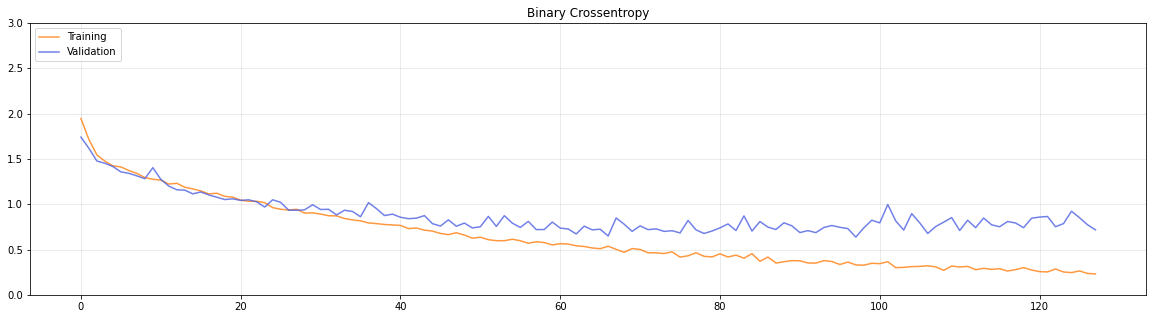

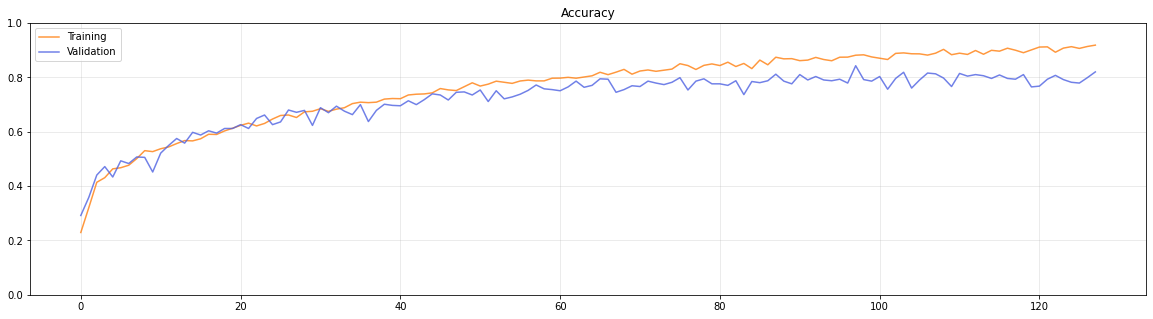

In [17]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.ylim(0, 3)
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.ylim(0, 1)
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

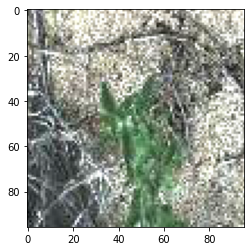

In [18]:
# Get sample batch
batch = next(val_set)[0]

# Get first image
image = batch[0]             

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

# Ouput images of the layers

In [19]:
# Get the activations (the output of each ReLU layer)
layers = [layer.output for layer in model_aug.layers if (isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D))]   #tf.keras.layers.Conv2D
activation_model = tf.keras.Model(inputs=model_aug.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))


1/1 [==============================] - 0s 170ms/step


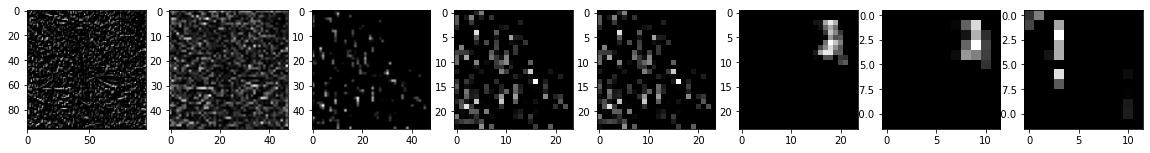

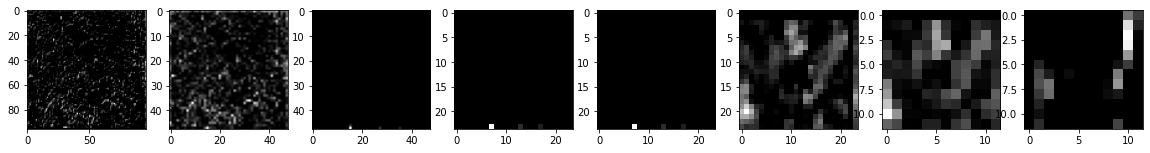

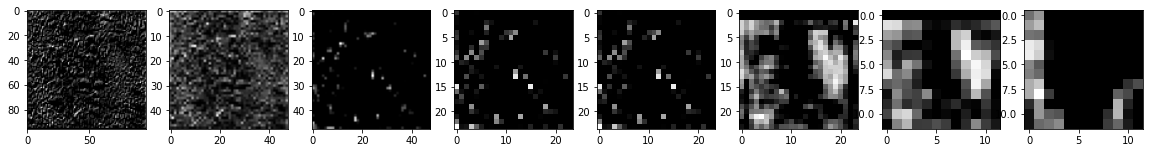

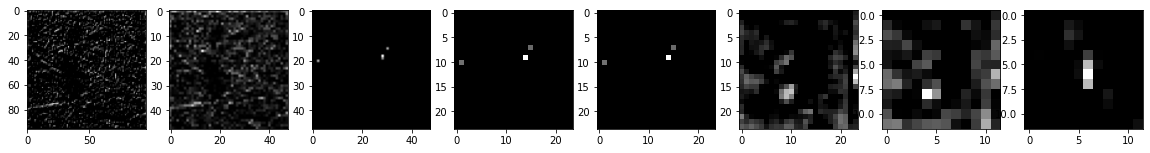

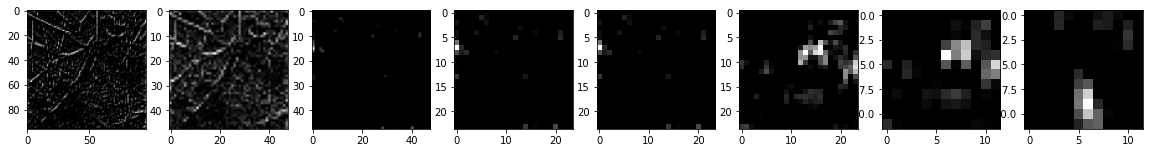

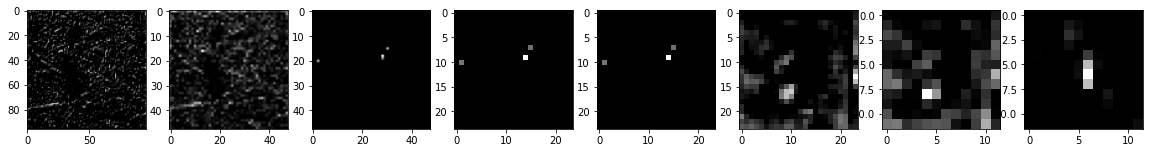

In [20]:
def plot_latent_filters(model, layers, image):
    fig, axes = plt.subplots(1, len(layers), figsize=(20,5))
    for j,layer in enumerate(layers):
        ax = axes[j]
        ax.imshow(tfk.Sequential(model.layers[:layer]).predict(tf.expand_dims(image,axis=0),verbose=0)[0,:,:,0], cmap='gray')
         
    plt.show()

layers = [1,2,3,4,5,6,7,8]
n = 6
#m = random.randint(0,7)
for i in range(n):
    plot_latent_filters(model_aug, layers, train_set[random.randint(0,len(train_set)-1)][0][3,:,:,:])
